In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [95]:
data = np.load('C:/Users/Lorenzo/Documents/Lubiana/Nnst/Data/camera11.npy')
signal = data[:,30,35]
nsec = 0.01
sampling_freq = 400
overlap = 0 
confidence = 95
plot_res = True

In [96]:
N = len(signal) #Number of points
dt = 1/sampling_freq
T = N*dt - dt
time = np.linspace(0, T, N)

ent_std = np.std(signal, ddof = 1) #Standard deviation of entire signal
ent_mean = np.mean(signal)

In [97]:
## Confidence interval
coeff = [1.645, 1.96, 2.326, 2.576]
conf = [90, 95, 98, 99]
alpha = coeff[conf.index(confidence)]

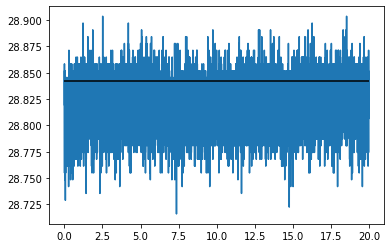

In [98]:
plt.plot(time,signal, zorder = 0)
plt.hlines(ent_std + ent_mean, 0, T, zorder = 1)

In [99]:
wdw_pts = int(np.floor(sampling_freq * nsec)) # Number of point for each window
seg_pts = wdw_pts - int(np.floor(wdw_pts * overlap))    # Number of point for each segment (considering overlap)
seg = int(np.ceil(N / seg_pts))                 # Number of segments
cls = np.array(np.array_split(signal, seg))

In [108]:
seg_std = np.std(cls, axis=1, ddof=1)
cls_std = np.std(seg_stdv, ddof = 1)
boundUP = ent_std + cls_std
boundDW = ent_std - cls_std

In [133]:
## Run computation
run = np.empty(seg)
for i in range(0, seg):
    if seg_std[i] > boundUP or seg_std[i] < boundDW:
        run[i] = 1
    else:
        run[i] = 0

N1 = 0
N0 = 0
for i in range(0, seg):
    if run[i] == 1.:
        N1 += 1
    else:
        N0 += 1
        
N = N1 + N0
Nr = 0

for i in range(1, seg):
    if run[i] != run[i-1]:
        Nr += 1

In [134]:
## Stationary limits 
run_mean = (2 * N1 * N0) / N + 1
run_var = (2 * N1 * N0 * (2 * N1 * N0 - N)) / (N**2 * (N - 1))

lim_up = run_mean + alpha * np.sqrt(run_var)
lim_dw = run_mean - alpha * np.sqrt(run_var)

index_up = np.round(100 * lim_up / mean_val, 2)
index_dw = np.round(100 * lim_dw / mean_val, 2)

if Nr >= lim_dw and Nr <= lim_up:   
    bns = 'Stationary'
else:
    bns = 'Non-stationary' 
    
## Index of non-stationary
index = np.round( 100 * Nr / run_mean, 2)
    
nnst = {'index': index, 'bns':bns, 'ind_dw':index_dw, 'ind_up':index_up}


In [135]:
nnst

{'index': 100.89, 'bns': 'Stationary', 'ind_dw': 95.62, 'ind_up': 104.38}

In [ ]:

if plot_res == True:
    plt.figure()
    plt.plot(time,signal, color = 'darkgray', zorder = 2, label = 'Signal')
    plt.hlines(np.mean(signal)+ent_stdv, 0, T, colors='C1', linestyles='solid', zorder = 4, label = 'Standard deviation')
    plt.plot(np.linspace(0,T,len(stdv)),np.mean(signal)+stdv, color = 'C0', zorder = 3, label = 'Standard deviation windows')
    plt.hlines(np.mean(signal) + boundUP, 0, T, colors='C3', linestyles='dashed', zorder = 5, label = 'Boundaries')
    plt.hlines(np.mean(signal) + boundDW, 0, T, colors='C3', linestyles='dashed', zorder = 6)
    plt.legend(loc=4)
    plt.grid(zorder = 1)
    plt.xlim([0,T])
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude [\]')
    plt.show()